In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)
import os
os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
from utilsforecast.plotting import plot_series as plot_series_utils
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
from fpppy.utils import plot_series

In [6]:
from tsfeatures import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#D55F03", "#569CC6", "#13A076", "#CC79A7"])

## Time series features
Lets do some simple statistics like mean:

In [7]:
aus_tourism = pd.read_csv("data/aus_tourism.csv", parse_dates=["ds"])
mean_df = aus_tourism.groupby("unique_id", as_index=False)["y"].mean()
mean_df.sort_values(by="y").head(10)

,unique_id,y
158,Kangaroo Island-South Australia-Other,0.340
182,MacDonnell-Northern Territory-Other,0.449
294,Wilderness West-Tasmania-Other,0.478
34,Barkly-Northern Territory-Other,0.632
86,Clare Valley-South Australia-Other,0.898
38,Barossa-South Australia-Other,1.022
154,Kakadu Arnhem-Northern Territory-Other,1.043
170,Lasseter-Northern Territory-Other,1.136
298,Wimmera-Victoria-Other,1.146
183,MacDonnell-Northern Territory-Visiting,1.175


In [8]:
summary_stats = tsfeatures(aus_tourism, freq=4, features=[statistics],
    scale=False)
summary_stats[["unique_id", "min", "p25", "median", "p75", "max"]].head(10)

,unique_id,min,p25,median,p75,max
0,Adelaide Hills-South Australia-Business,0.000,0.000,1.255,3.920,28.602
1,Adelaide Hills-South Australia-Holiday,0.000,5.768,8.516,14.060,35.751
2,Adelaide Hills-South Australia-Other,0.000,0.000,0.908,2.093,8.953
3,Adelaide Hills-South Australia-Visiting,0.778,8.908,12.207,16.806,81.102
4,Adelaide-South Australia-Business,68.725,133.893,152.577,176.936,242.494
5,Adelaide-South Australia-Holiday,108.033,134.627,153.945,172.257,223.557
6,Adelaide-South Australia-Other,25.902,43.866,53.809,62.523,107.495
7,Adelaide-South Australia-Visiting,136.611,178.916,205.582,229.299,269.536
8,Alice Springs-Northern Territory-Business,1.008,9.133,13.324,18.456,34.077
9,Alice Springs-Northern Territory-Holiday,2.809,16.851,31.524,44.784,76.541


## ACF features

We can calcualte the autorcorrelations of e changes in the series between periods or the differnce in data and create a new time sereis made up of hte differences between consectuve observations. Then we can calculate the autocorrelatiosn of this new differenced series.

We do this by setting features = [acf_features] and returns six/seven fetures
- The first autocorrelation coeffcient from the original data
- The sum of squares of the frist ten autocorrelation coefficients from the original data
- The first autocorrelation coefficient form the differenced data
- The sum of squares of the first ten autocorrelation coefficients fomr the differenced data
- the first autocorrelation coefficient from the twice differenced data;
- the sum of squares of the first ten autocorrelation coefficients from the twice differenced data
- For seasonal data, the autocorrelation coefficient at the first seasonal lag is also returned.

In [10]:
acf_feat = tsfeatures(aus_tourism, freq=4, features=[acf_features])
acf_feat.head(10)

,unique_id,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,Adelaide Hills-South Australia-Business,0.071,0.134,-0.580,0.415,-0.750,0.746,-0.063
1,Adelaide Hills-South Australia-Holiday,0.131,0.313,-0.536,0.500,-0.716,0.906,0.208
2,Adelaide Hills-South Australia-Other,0.261,0.330,-0.253,0.317,-0.457,0.392,0.075
3,Adelaide Hills-South Australia-Visiting,0.139,0.117,-0.472,0.239,-0.626,0.408,0.170
4,Adelaide-South Australia-Business,0.033,0.131,-0.520,0.463,-0.676,0.741,0.201
5,Adelaide-South Australia-Holiday,0.046,0.372,-0.343,0.614,-0.487,0.558,0.351
6,Adelaide-South Australia-Other,0.517,1.154,-0.409,0.383,-0.675,0.792,0.342
7,Adelaide-South Australia-Visiting,0.068,0.294,-0.394,0.452,-0.518,0.447,0.345
8,Alice Springs-Northern Territory-Business,0.217,0.367,-0.500,0.381,-0.658,0.587,0.315
9,Alice Springs-Northern Territory-Holiday,-0.007,2.113,-0.153,2.113,-0.274,1.551,0.729


## STL Features

Recall Decomposition is written as:

$$y_t = T_t + S_t + R_t$$

Where $T_t$ is the smoothed trend component, $S_t$ is the seasonal component, and $R_t$ is the remainder component. For strongly tended data, the saesonally adjusted data should have muc more variation than the remainder component. Therefore $Var(R_t)/Var(T_t+R_t)$ should be relatively small.But if ther is little to no trned the two variances should be rouhgly the same and we dffine the strendth of trend as:

$$F_T = max(0, 1 - \frac{Var(R_t)}{Var(T_t + R_t)})$$
This givrs a measure of the strength of the trend with a value between 0 and 1.

There is also a seasonally adjusted strength indicator:

$$F_S = max(0, 1 - \frac{Var(R_t)}{Var(S_t + R_t)})$$

In [11]:
stl_feat = tsfeatures(aus_tourism, freq=4, features=[stl_features])
stl_feat.head(10)

,unique_id,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,seasonal_strength,peak,trough
0,Adelaide Hills-South Australia-Business,1,4,0.460,3.223e-04,0.278,-0.627,-0.594,0.502,0.168,3,4
1,Adelaide Hills-South Australia-Holiday,1,4,0.531,1.048e-04,1.669,3.925,-0.456,0.342,0.295,2,4
2,Adelaide Hills-South Australia-Other,1,4,0.590,5.346e-05,2.486,1.898,-0.295,0.273,0.407,2,2
3,Adelaide Hills-South Australia-Visiting,1,4,0.487,5.798e-04,3.231,-0.125,-0.474,0.438,0.248,4,3
4,Adelaide-South Australia-Business,1,4,0.462,9.712e-05,-0.106,2.049,-0.538,0.577,0.391,3,1
5,Adelaide-South Australia-Holiday,1,4,0.578,1.717e-05,1.850,3.028,-0.525,0.600,0.638,1,2
6,Adelaide-South Australia-Other,1,4,0.746,2.364e-05,5.548,2.493,-0.368,0.412,0.209,2,3
7,Adelaide-South Australia-Visiting,1,4,0.449,4.824e-05,1.033,2.267,-0.504,1.000,0.476,1,2
8,Alice Springs-Northern Territory-Business,1,4,0.552,5.246e-05,3.299,2.586,-0.481,0.519,0.302,3,1
9,Alice Springs-Northern Territory-Holiday,1,4,0.379,6.707e-06,-1.076,0.634,-0.529,0.709,0.832,3,1


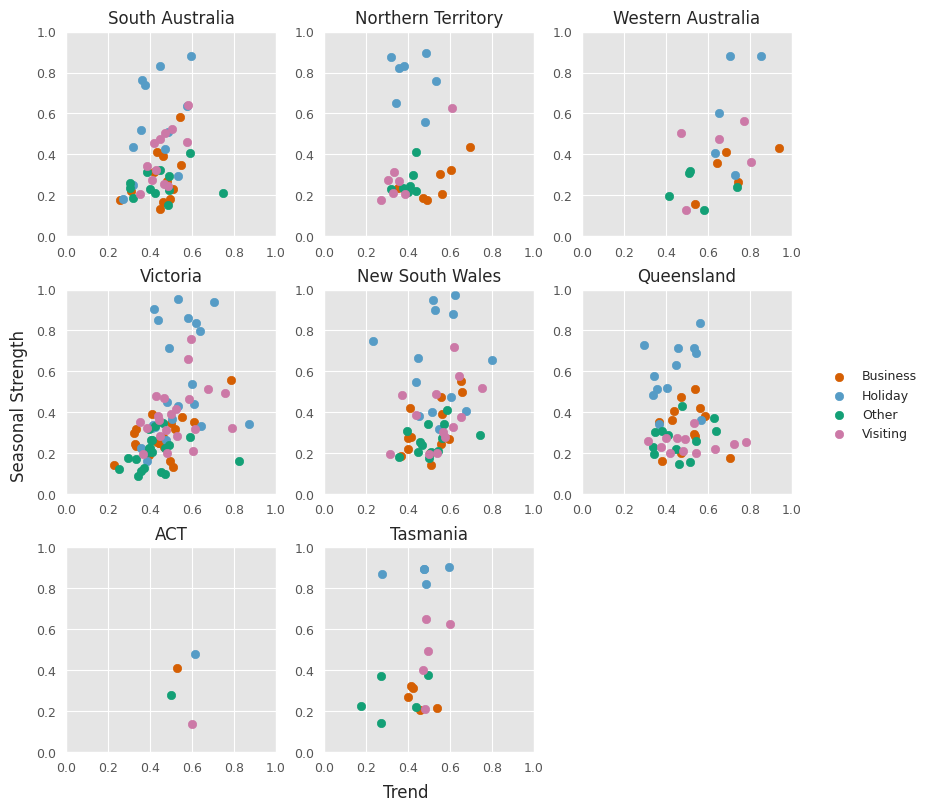

In [12]:
stl_feat[["region", "state", "purpose"]] = stl_feat["unique_id"].str.split(
    "-", expand=True
)

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
unique_states = stl_feat["state"].unique()
all_handles = []
all_labels = []
for i, state in enumerate(unique_states):
    state_df = stl_feat.query("state == @state")
    ax = axs[i]
    for purpose in state_df["purpose"].unique():
        purpose_df = state_df[state_df["purpose"] == purpose]
        handle = ax.scatter(
            purpose_df["trend"], purpose_df["seasonal_strength"],
            label=purpose
        )
        if purpose not in all_labels:
            all_handles.append(handle)
            all_labels.append(purpose)
    ax.set_title(state)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
fig.legend(
    all_handles, all_labels, loc="center left", bbox_to_anchor=(1.02, .5),
    frameon=False, borderaxespad=0,
)
fig.supxlabel('Trend')
fig.supylabel('Seasonal Strength')

# Remove any empty subplots
for j in range(len(unique_states), len(axs)):
    fig.delaxes(axs[j])

plt.show()

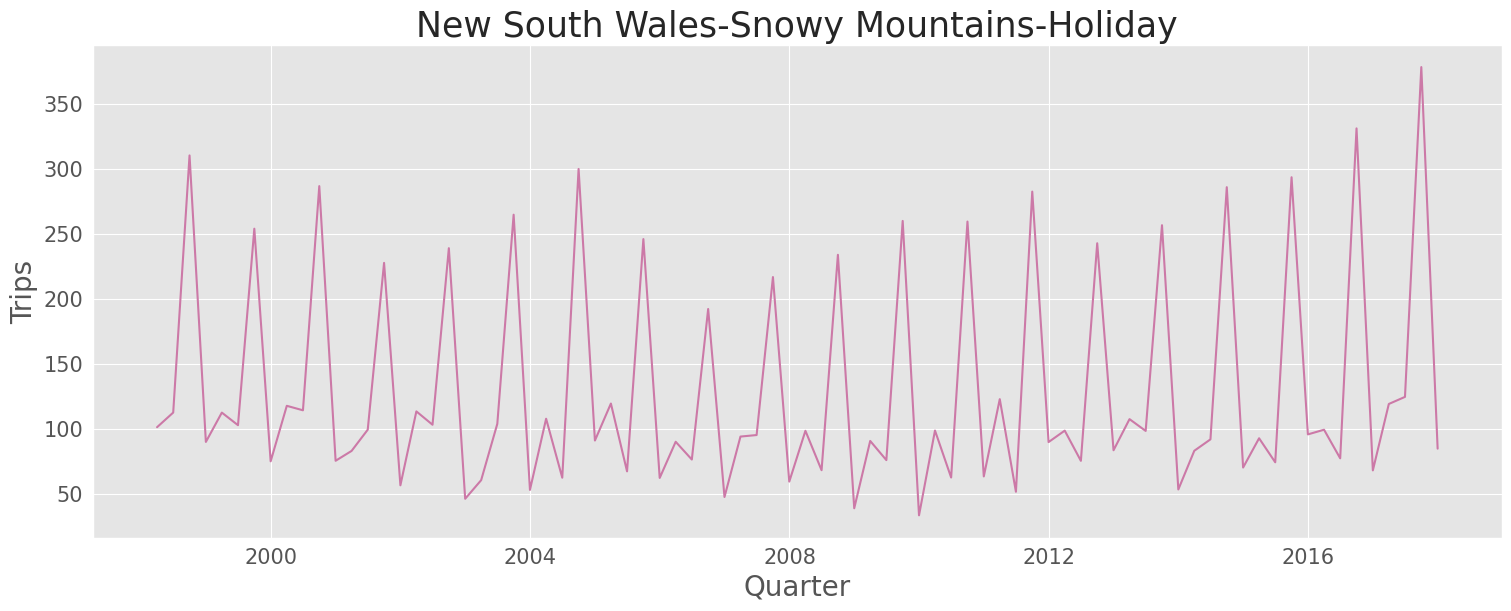

In [13]:
max_seasonal_strength_row = \
    stl_feat.loc[stl_feat["seasonal_strength"].idxmax()]
max_unique_id = max_seasonal_strength_row["unique_id"]
aus_tourism["ds"] = pd.to_datetime(aus_tourism["ds"])
plot_series(aus_tourism, ids=[max_unique_id],
            xlabel="Quarter", ylabel="Trips",
            title="New South Wales-Snowy Mountains-Holiday")

## 4,5 More with tsfeatures



In [14]:
all_features = [
    acf_features,
    arch_stat,
    crossing_points,
    entropy,
    flat_spots,
    heterogeneity,
    holt_parameters,
    lumpiness,
    nonlinearity,
    pacf_features,
    stl_features,
    stability,
    hw_parameters,
    unitroot_kpss,
    unitroot_pp,
    series_length,
    hurst,
]
all_feat = tsfeatures(aus_tourism, freq=4, features=all_features)
all_feat.head(10)

,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,entropy,crossing_points,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,Adelaide Hills-South Australia-Business,NaN,80,-80.527,0.060,1.490e-08,1.220e-08,0.00,0.294,1,...,0.895,36,0.014,0.071,0.134,-0.580,0.415,-0.750,0.746,-0.063
1,Adelaide Hills-South Australia-Holiday,0.823,80,-74.302,0.476,9.899e-02,9.899e-02,0.00,0.409,1,...,0.831,33,0.121,0.131,0.313,-0.536,0.500,-0.716,0.906,0.208
2,Adelaide Hills-South Australia-Other,0.599,80,-55.385,0.605,1.490e-08,1.481e-08,0.18,0.274,1,...,0.862,37,0.265,0.261,0.330,-0.253,0.317,-0.457,0.392,0.075
3,Adelaide Hills-South Australia-Visiting,0.757,80,-71.076,0.749,1.490e-08,1.150e-09,0.00,0.333,1,...,0.907,25,0.005,0.139,0.117,-0.472,0.239,-0.626,0.408,0.170
4,Adelaide-South Australia-Business,0.840,80,-78.764,0.221,1.306e-01,1.306e-01,0.00,0.318,1,...,0.848,43,0.183,0.033,0.131,-0.520,0.463,-0.676,0.741,0.201
5,Adelaide-South Australia-Holiday,0.709,80,-72.567,0.449,1.758e-01,1.758e-01,0.00,0.312,1,...,0.737,36,0.161,0.046,0.372,-0.343,0.614,-0.487,0.558,0.351
6,Adelaide-South Australia-Other,0.776,80,-36.405,1.406,1.068e-01,7.715e-02,0.00,0.574,1,...,0.755,28,0.456,0.517,1.154,-0.409,0.383,-0.675,0.792,0.342
7,Adelaide-South Australia-Visiting,0.737,80,-74.137,0.264,1.630e-01,0.000e+00,0.00,0.267,1,...,0.776,42,0.173,0.068,0.294,-0.394,0.452,-0.518,0.447,0.345
8,Alice Springs-Northern Territory-Business,0.673,80,-65.845,0.807,1.456e-01,0.000e+00,0.00,0.439,1,...,0.851,33,0.425,0.217,0.367,-0.500,0.381,-0.658,0.587,0.315
9,Alice Springs-Northern Territory-Holiday,0.579,80,-54.382,0.387,1.490e-08,7.911e-09,0.00,0.084,1,...,0.412,40,0.304,-0.007,2.113,-0.153,2.113,-0.274,1.551,0.729


With this we have 42 featyres for every combination of three key variables of (Region, State, Purpose). We can do pairwise plots of groups of feautres.

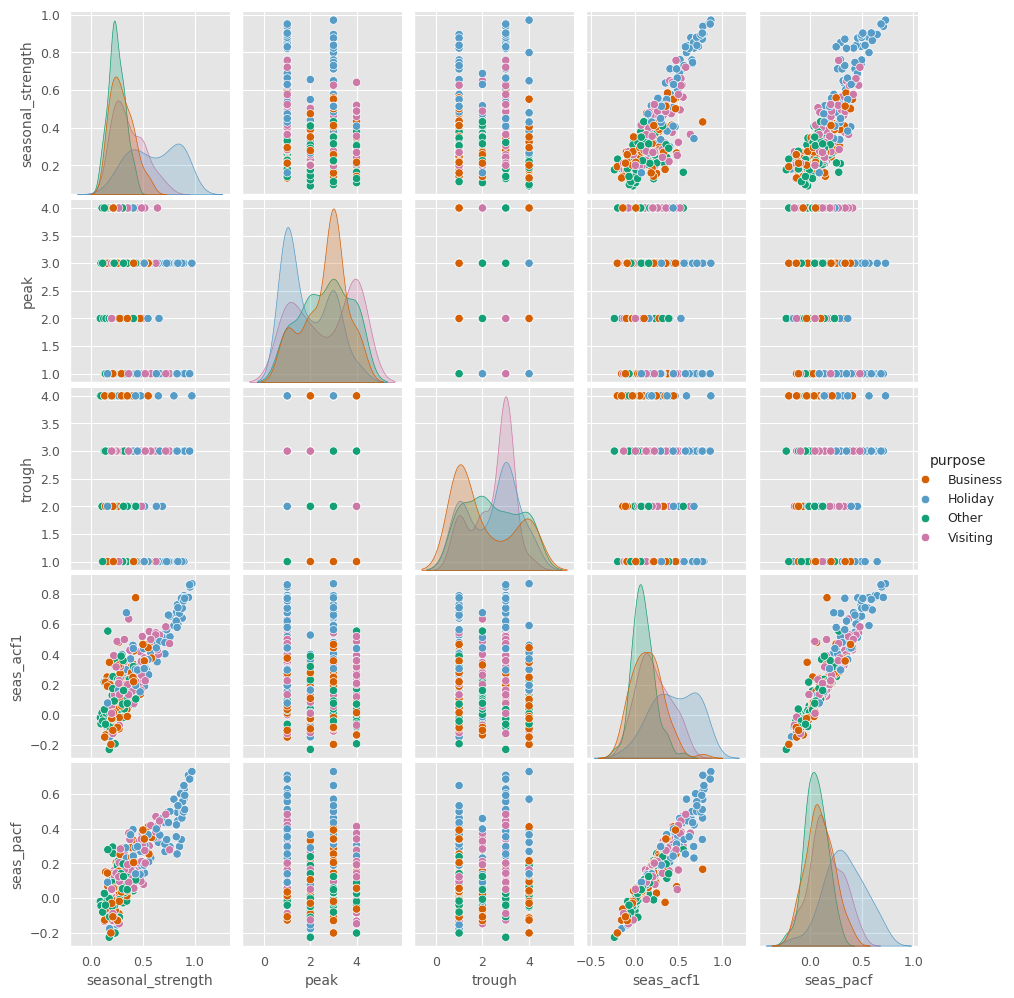

In [15]:
seasonal_feat = all_feat[
    ["unique_id", "seasonal_strength", "peak", "trough",
     "seas_acf1", "seas_pacf"]
]
seasonal_feat[["region", "state", "purpose"]] = \
    seasonal_feat["unique_id"].str.split("-", expand=True)
g = sns.pairplot(seasonal_feat, hue="purpose")
g.fig.set_size_inches(10, 10)
plt.show()

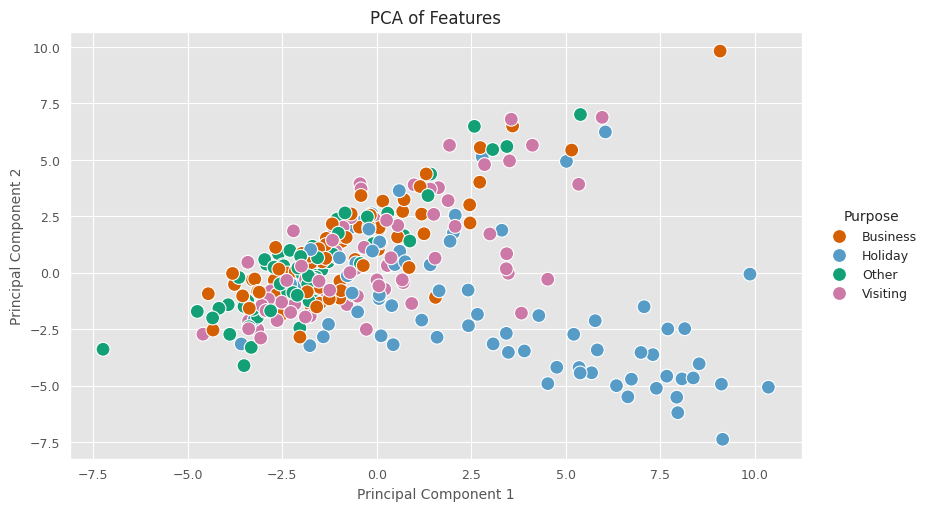

In [16]:
all_feat['purpose'] = all_feat['unique_id'].str.split('-').str[-1]
all_feat = all_feat.dropna(axis=1)

features = all_feat.columns.drop(["unique_id", "purpose"])
X = all_feat[features]
y = all_feat["purpose"]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Plotting the first two PCA components
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
pca_df["purpose"] = y

fig, ax = plt.subplots()
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="purpose", s=100, ax=ax)
ax.set_title("PCA of Features")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Purpose", loc="center left", bbox_to_anchor=(1.02, .5),
    frameon=False, borderaxespad=0)
plt.show()

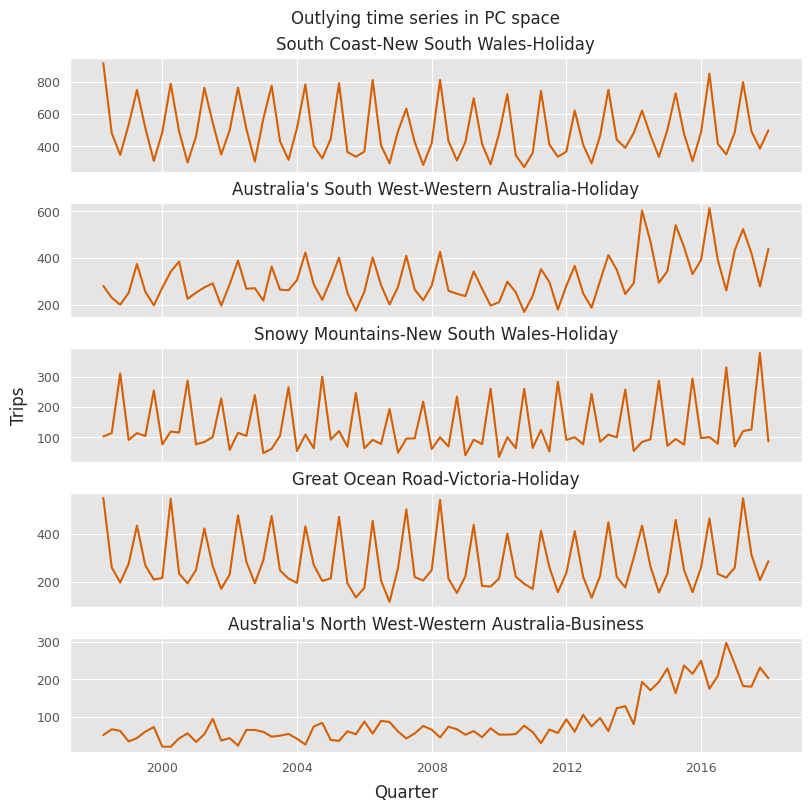

In [17]:
pca_df["unique_id"] = all_feat["unique_id"]
top_unique_ids = pca_df.nlargest(5, "PC1")["unique_id"]
plot_df = aus_tourism[aus_tourism["unique_id"].isin(top_unique_ids)]

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

for i, unique_id in enumerate(top_unique_ids):
    subset = plot_df[plot_df["unique_id"] == unique_id]
    axs[i].plot(subset["ds"], subset["y"])
    axs[i].set_title(unique_id)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
fig.suptitle("Outlying time series in PC space", x=0.525)
fig.supylabel("Trips")
fig.supxlabel("Quarter")
plt.show()